# Using doNd functions in comparison to Measurement context manager for performing measurements

This example notebook contains simple cases in which the `doNd` utilities of QCoDeS can be used to perform experiments. The `doNd` functions are generic wrappers of QCoDeS Measurement in zero, one and two dimensions. To have a better picture of the difference between two approaches, we compare `doNd` and Measurement side-by-side. In what follows, we shall provide the most basic functionalities and leave more detailed practices to the user. In particular, we shall not concern about single point measurements.

In [1]:
from functools import partial
import os

import time
import numpy as np

from qcodes.utils.dataset.doNd import do1d, do2d, plot
from qcodes.dataset.sqlite.database import initialise_or_create_database_at
from qcodes.dataset.experiment_container import load_or_create_experiment
from qcodes.dataset.data_set import load_by_run_spec
from qcodes.tests.instrument_mocks import DummyInstrument, DummyInstrumentWithMeasurement
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_dataset

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/vsts/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


Qcodes Logfile : /home/vsts/.qcodes/logs/210115-15357-qcodes.log


In [2]:
tutorial_db_path = os.path.join(os.getcwd(), 'tutorial_doNd.db')
initialise_or_create_database_at(tutorial_db_path)

0it [00:00, ?it/s]

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v1 -> v2:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v1 -> v2: 100%|██████████| 1/1 [00:00<00:00, 463.82it/s]


0it [00:00, ?it/s]

Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]

Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]

Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v4 -> v5:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v4 -> v5: 100%|██████████| 1/1 [00:00<00:00, 526.20it/s]


0it [00:00, ?it/s]

Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]

Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v6 -> v7:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v6 -> v7: 100%|██████████| 1/1 [00:00<00:00, 284.38it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v7 -> v8:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v7 -> v8: 100%|██████████| 1/1 [00:00<00:00, 594.26it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v8 -> v9:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v8 -> v9: 100%|██████████| 1/1 [00:00<00:00, 993.44it/s]

First we setup two dummy instruments to have something to measure. The dmm is setup to generate an output depending on the values set on the dac simulating a real experiment.

In [3]:
# preparatory mocking of physical setup
dac = DummyInstrument('dac', gates=['ch1', 'ch2'])
dmm = DummyInstrumentWithMeasurement('dmm', setter_instr=dac)

We create an experiment for the purpose of this notebook.

In [4]:
tutorial_exp = load_or_create_experiment('doNd_VS_Measurement', sample_name='no sample')

### 1D measurement

##### Measurement

We perform a one-dimensional sweep over a dac channel to measure our dmm voltages.

In [5]:
# Setting up Measurement
meas = Measurement()
meas.register_parameter(dac.ch1)
meas.register_parameter(dmm.v1, setpoints=(dac.ch1,))
meas.register_parameter(dmm.v2, setpoints=(dac.ch1,))

# Running Measurement
with meas.run() as datasaver:
    for dac_sweep in np.linspace(0, 1, 10): # sweep points
        dac.ch1(dac_sweep)
        datasaver.add_result(
            (dac.ch1, dac.ch1()),
            (dmm.v1, dmm.v1()),
            (dmm.v2, dmm.v2())
            )
        time.sleep(0.01) # Can be removed if there is no intention to see a live plot

    dataset1 = datasaver.dataset

Starting experimental run with id: 1. 


([<AxesSubplot:title={'center':'Run #1, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate v1 (V)'>,
  <AxesSubplot:title={'center':'Run #1, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate v2 (mV)'>],
 [None, None])

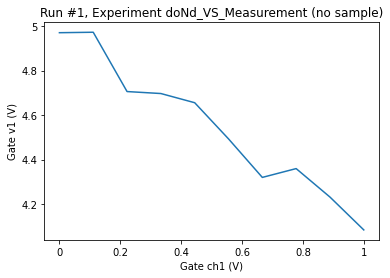

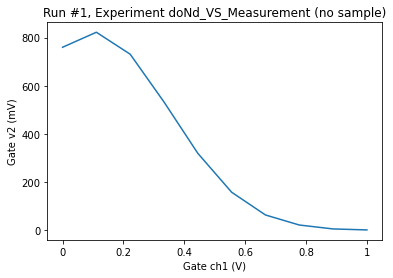

In [6]:
plot_dataset(dataset1)

##### do1d

Now let us use `do1d` function to perform the above measurement.

In [7]:
# Running masurement with do1d
do1d(dac.ch1, 0, 1, 10, 0.01, dmm.v1, dmm.v2)

Starting experimental run with id: 2. 


(results #2@/home/vsts/work/1/s/docs/examples/DataSet/tutorial_doNd.db
 ---------------------------------------------------------------------
 dac_ch1 - numeric
 dmm_v1 - numeric
 dmm_v2 - numeric,
 [None],
 [None])

By comparing `do1d` to a measurement implemented using the Measurement context manager we notice that 
the do1d is significantly shorter and much less typing is required to perform a basic measurement. This does however come at the cost of loss of flexibility. The `doNd` functions are therefor great for simple 0d, 1d and 2d measurements but if you need to implement a more complicated type of measurement the Measurement context manager is more well suited.

By default the `doNd` functions  will not generate a plot of the output. This can be changed in one of two ways. For each individual call to doNd, one can set the value of the keyword argument `do_plot` to True. Alternatively, one can globally set the value of the setting `dataset.dond_plot` in the `qcodesrc.json` configuration file. In the examples below we will often set `do_plot` to True to illustrate how the dond functions work. Note that this setting will be resulting to save the ouput as `png` and `pdf`.

For most use cases we recommed using [Plottr](https://github.com/toolsforexperiments/plottr/) for live plotting. See [How to use plottr with QCoDeS for live plotting](../plotting/How-to-use-Plottr-with-QCoDeS-for-live-plotting.ipynb) for an introduction to Plottr.

Starting experimental run with id: 3. 


(results #3@/home/vsts/work/1/s/docs/examples/DataSet/tutorial_doNd.db
 ---------------------------------------------------------------------
 dac_ch1 - numeric
 dmm_v1 - numeric
 dmm_v2 - numeric,
 [<AxesSubplot:title={'center':'Run #3, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate v1 (V)'>,
  <AxesSubplot:title={'center':'Run #3, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate v2 (mV)'>],
 [None, None])

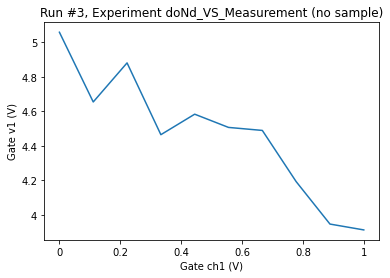

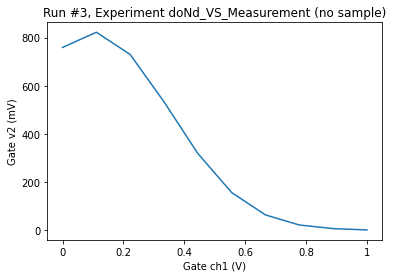

In [8]:
do1d(dac.ch1, 0, 1, 10, 0.01, dmm.v1, dmm.v2, do_plot = True)

Note that since DummyInstrumentWithMeasurement.v1 and v2 returns a result with simulated random noise the results are not exactly the same as above.

### 2D measurement

Now, let us have a two dimensional sweep over gate voltages:

##### Measurement

In [9]:
# Setting up Measurement
meas = Measurement()
meas.register_parameter(dac.ch1)
meas.register_parameter(dac.ch2)
meas.register_parameter(dmm.v1, setpoints=(dac.ch1,dac.ch2))
meas.register_parameter(dmm.v2, setpoints=(dac.ch1,dac.ch2))

# Running Measurement
with meas.run() as datasaver:
    for dac1_sweep in np.linspace(-1, 1, 20): # sweep points over channel 1
        dac.ch1(dac1_sweep)
        for dac2_sweep in np.linspace(-1, 1, 20): # sweep points over channel 2
            dac.ch2(dac2_sweep)
            datasaver.add_result(
                (dac.ch1, dac.ch1()),
                (dac.ch2, dac.ch2()),
                (dmm.v1, dmm.v1()),
                (dmm.v2, dmm.v2())
                )
            time.sleep(0.01) # Can be removed if there is no intention to see a live plot

    dataset2 = datasaver.dataset

Starting experimental run with id: 4. 


([<AxesSubplot:title={'center':'Run #4, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate ch2 (V)'>,
  <AxesSubplot:title={'center':'Run #4, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate ch2 (V)'>],
  <matplotlib.colorbar.Colorbar at 0x7fb8d2cd7d50>])

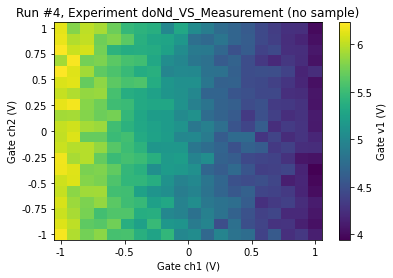

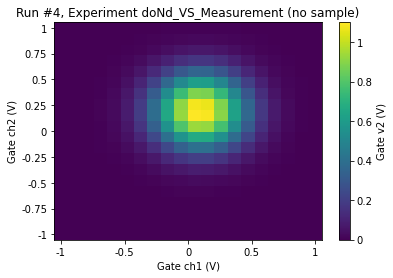

In [10]:
plot_dataset(dataset2)

##### do2d

Again, we use `do2d` to produce the results for the above measurement. As explained earlier, the results might look different compared to the Measurement section

Starting experimental run with id: 5. 


(results #5@/home/vsts/work/1/s/docs/examples/DataSet/tutorial_doNd.db
 ---------------------------------------------------------------------
 dac_ch1 - numeric
 dac_ch2 - numeric
 dmm_v1 - numeric
 dmm_v2 - numeric,
 [<AxesSubplot:title={'center':'Run #5, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate ch2 (V)'>,
  <AxesSubplot:title={'center':'Run #5, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate ch2 (V)'>],
  <matplotlib.colorbar.Colorbar at 0x7fb8d2b028d0>])

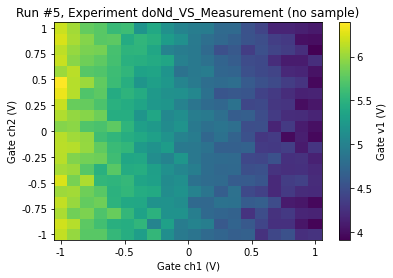

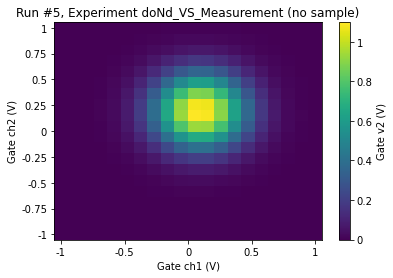

In [11]:
# Running masurement with do2d
do2d(dac.ch1, -1, 1, 20, 0.01, dac.ch2, -1, 1, 20, 0.01, dmm.v1, dmm.v2, do_plot = True)

### Handling plot and experiment with doNd

As discussed above the `doNd` functions can be configured to automatically call `plot_dataset` and save the output to `png` and `pdf` files. It is however also possible to generate these plots using the `plot` function in the dond module after a measurement is performed.

The `doNd` functions return a tuple of the dataset obtained in the measurement, a List of Matplotlib axes and a list of Matplotlib colorbars and plot takes a dataset to be plotted along with keyword arguments that determine if a png or pdf file should be saved. One should therefor pass the first element of the tuple returned by `doNd` to the plot function.

As with the Measurement context manager, it is possible to pass an explicit experiment to the `doNd` functions. Then, one can switch between experiments when using the `doNd` functions.

In [12]:
result_1d = do1d(dac.ch1, 0, 0.25, 10, 0.01, dmm.v1, dmm.v2, exp=tutorial_exp)

Starting experimental run with id: 6. 


In [13]:
result_2d = do2d(dac.ch1, -0.6, 0.6, 20, 0.01, dac.ch2, -0.6, 0.6, 20, 0.01, dmm.v1, dmm.v2, exp=tutorial_exp)

Starting experimental run with id: 7. 


(results #6@/home/vsts/work/1/s/docs/examples/DataSet/tutorial_doNd.db
 ---------------------------------------------------------------------
 dac_ch1 - numeric
 dmm_v1 - numeric
 dmm_v2 - numeric,
 [<AxesSubplot:title={'center':'Run #6, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (mV)', ylabel='Gate v1 (V)'>,
  <AxesSubplot:title={'center':'Run #6, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (mV)', ylabel='Gate v2 (mV)'>],
 [None, None])

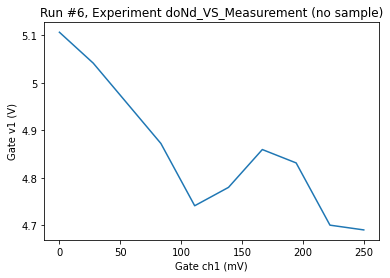

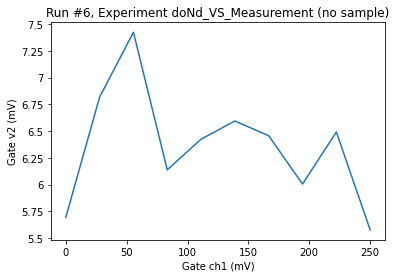

In [14]:
plot(result_1d[0], save_pdf = False, save_png =True)

(results #7@/home/vsts/work/1/s/docs/examples/DataSet/tutorial_doNd.db
 ---------------------------------------------------------------------
 dac_ch1 - numeric
 dac_ch2 - numeric
 dmm_v1 - numeric
 dmm_v2 - numeric,
 [<AxesSubplot:title={'center':'Run #7, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (mV)', ylabel='Gate ch2 (mV)'>,
  <AxesSubplot:title={'center':'Run #7, Experiment doNd_VS_Measurement (no sample)'}, xlabel='Gate ch1 (mV)', ylabel='Gate ch2 (mV)'>],
  <matplotlib.colorbar.Colorbar at 0x7fb8d31aeb10>])

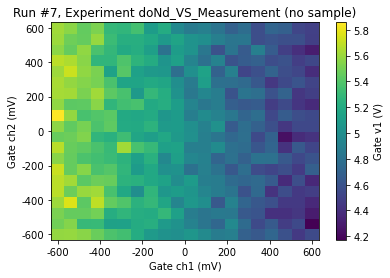

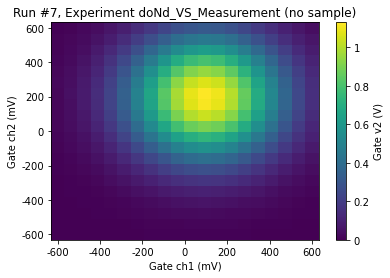

In [15]:
plot(result_2d[0], save_pdf = True, save_png = False)